## Modules à importer

In [2]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean et std + cons

In [3]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [4]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values

def set_cons(cons):
    global df
    
    names = []
    stretchs = []
    stretchs_err = []
    redshifts = []
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        if survey != 'SNF':
            infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
            py += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])

    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(z_zcuts['SNF']))]
stretchs = list(x1_zcuts['SNF'])
stretchs_err = list(x1_err_zcuts['SNF'])
redshifts = list(z_zcuts['SNF'])
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

df_nc = set_cons(False)
df_c = set_cons(True)

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

# Individual model plots

In [5]:
gen = stretchevol.generic()

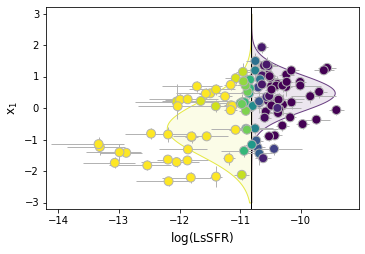

In [6]:
gen.set_model('Evol2G2M2S')
gen.set_data(df)
how = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

how.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
            facealpha=1, show_leg=False)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

fig.savefig('../../../../Images/model_howell.pdf', bbox_inches='tight')

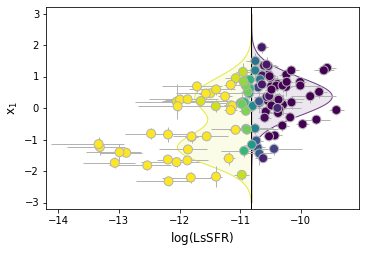

In [17]:
gen.set_model('Evol3G2M2S')
gen.set_data(df)
base = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

base.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
            facealpha=1, show_leg=False)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

fig.savefig('../../../../Images/model_base.pdf', bbox_inches='tight')

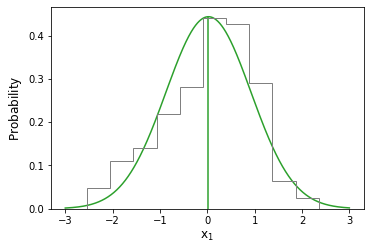

In [16]:
gen.set_model('Evol1G1M1S')
gen.set_data(df)
gauss = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

gauss.show_model_tot(ax=ax)
fig.savefig('../../../../Images/model_gauss.pdf', bbox_inches='tight')

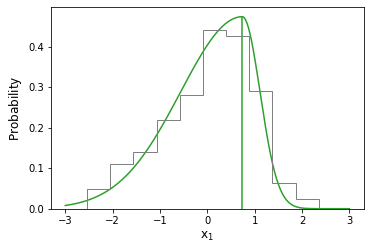

In [20]:
gen.set_model('Evol1G1M2S')
gen.set_data(df)
asymm = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

asymm.show_model_tot(ax=ax)
fig.savefig('../../../../Images/model_asymm.pdf', bbox_inches='tight')

## Comparison plot

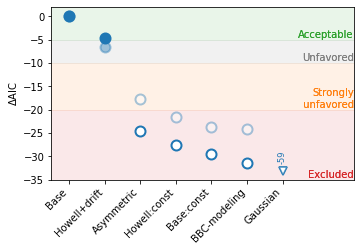

In [10]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py = pd.read_csv('../../Data/df_comparaison.dat')
d_mod_comp_cons = pd.read_csv('../../Data/df_comparaison_cons.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
    prop_notfixed = dict(mfc="C0", mec="C0")
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../Images/mod_comp.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mod_comp.png', bbox_inches='tight', dpi=600)

## With _z-only_

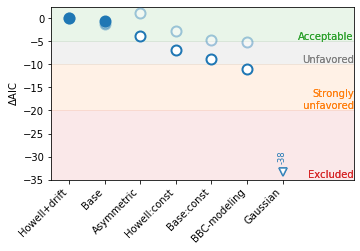

In [8]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py = pd.read_csv('../../Data/df_comparaison_zonly.dat')
d_mod_comp_cons = pd.read_csv('../../Data/df_comparaison_zonly_cons.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
    prop_notfixed = dict(mfc="C0", mec="C0")
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2.5)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../Images/mod_comp_zonly.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mod_comp_zonly.png', bbox_inches='tight', dpi=600)